# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
%%bash 
if [ -d itps_voice_recognition ]; then
  cd itps_voice_recognition
  git pull -r 
  cd ..
else 
  git clone https://github.com/iTPS-Inc/itps_voice_recognition.git
fi

if [ ! -f installed ]; then 


pip install boto3
pip install datasets==1.13.3
pip install transformers==4.11.3
pip install librosa
pip install jiwer
pip install sentencepiece
pip install japanize_matplotlib
pip install -Uqq fastai 
pip install neptune-client
apt-get -q -y install mecab file libmecab-dev mecab-ipadic-utf8 git curl python-mecab
git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git 
echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n  -y
ln -s /etc/mecabrc /usr/local/etc/mecabrc
pip install mecab-python3

touch installed
fi

In [ ]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("itps_voice_recognition")
from dsets.dsets import ENGLISH_DATASETS, get_datasets, JAPANESE_DATASETS
from dsets.dset_config.dset_config import DatasetConfig

from dsets.helpers.helpers import apply_parallel, get_sampling_rates
from itpsaudio.transforms import * 
from itpsaudio.core import * 
os.chdir("..")

# Imports 

In [ ]:
from fastai.data.all import * 
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForMaskedLM, AutoTokenizer, Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
from fastai.text.all import * 
from fastai.vision.all import *
from fastai.callback.tensorboard import *
import torchaudio
from fastai.callback.neptune import NeptuneCallback
import neptune 
import pandas
import MeCab
from pathlib import Path
from IPython.display import Audio, display
import japanize_matplotlib
import jiwer
import pickle
from datasets import load_metric
dset_lengths = None
TEST_RUN=False

In [ ]:
df = load_dataset("common_voice", "ja",split="train")

Downloading:   0%|          | 0.00/4.44k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset common_voice downloaded and prepared to /root/.cache/huggingface/datasets/common_voice/ja/6.1.0/f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9. Subsequent calls will reuse this data.


In [ ]:
datasets = JAPANESE_DATASETS[1:] # Don't include itps dataset for now
p, df1 = get_datasets(datasets)

In [ ]:
df = pd.DataFrame({"filename": pd.Series(df["path"]), "text": pd.Series(df["sentence"])})

In [ ]:
df = pd.concat([df, df1[["filename", "text"]]], ignore_index=True)
if TEST_RUN:
  df = df.iloc[:100]

# Model Training

In [ ]:
from functools import lru_cache
@lru_cache(maxsize=None)
def get_audio_length(s):
  t, sr = torchaudio.load(s)
  return len(t[0])/sr

In [ ]:
from transformers import Wav2Vec2CTCTokenizer
jp_vocab = "/content/drive/MyDrive/data/models/audio_jp/jp_vocab_file.json"
wav2vec2tok = Wav2Vec2CTCTokenizer(jp_vocab,
                                   bos_token="[BOS]",
                                   eos_token="[EOS]",
                                   unk_token="[UNK]",
                                   )

node_format_csv = r"%f[7]|"
eos_format_csv  = r"[EOS]\n"
unk_format_csv = r"%m|"
m = MeCab.Tagger(f" --node-format='{node_format_csv}'"+ 
                f" --unk-format='{unk_format_csv}'"+
                f" --eos-format='{eos_format_csv}'"+
                " -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
                )
tok = JPTransformersTokenizer(wav2vec2tok, m)

In [12]:
df["audio_length"] = df["filename"].apply(get_audio_length)

In [13]:
df["audio_length"].max()

18.6309375

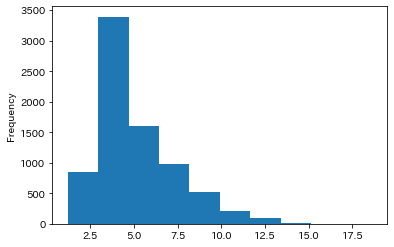

In [14]:
df["audio_length"].plot.hist()

In [15]:
df["audio_length"].sum() / 60 / 60

10.865605711805555

In [16]:
df = df[df["audio_length"]<15].reset_index(drop=True)
df = df[~df["text"].isna()].reset_index(drop=True)

In [17]:
df["audio_length"].sum() / 60 / 60

10.847086006944444

In [18]:
splits=RandomSplitter(valid_pct=0.2)(df)

In [19]:
pretrained_model_name = "facebook/wav2vec2-xls-r-300m"
pretrained_model_name = "facebook/hubert-large-ll60k"
tfms = TfmdLists(df, AudioBatchTransform(), splits=splits)

In [20]:
from transformers import AutoModelForCTC
model = AutoModelForCTC.from_pretrained(
    # "/content/drive/MyDrive/data/models/audio_jp/",
    pretrained_model_name,
    attention_dropout=0.08,
    hidden_dropout=0.08,
    feat_proj_dropout=0.08,
    mask_time_prob=0.05,
    mask_feature_prob=0.05,
    layerdrop=0.08,
    # ctc_loss_reduction="mean", 
    ctc_zero_infinity=True,
    pad_token_id=tok.tokenizer.pad_token_id,
    vocab_size=len(tok.tokenizer),
).cuda()

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ll60k and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from functools import lru_cache

@lru_cache(maxsize=None)
def get_sr(x):
    _, sr=torchaudio.load(x)
    return sr

if not "sr" in df.columns:
  df["sr"] = df["filename"].apply(get_sr)


In [ ]:
df["sr"].unique()

In [ ]:
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"

with open("noise_sample.wav", "wb") as f:
    r = requests.get(SAMPLE_NOISE_URL)
    f.write(r.content)

noise, sr = torchaudio.load("noise_sample.wav")
noise = TensorAudio(noise, sr=sr)


class Range():
  def __init__(self, start, stop):
    self.start, self.stop = start, stop

In [ ]:
import torchaudio.transforms as T
from itpsaudio.aug_transforms import AddNoise, RandomReverbration
from itpsaudio.callbacks import MixedPrecisionTransformers
train_text_lens = df.loc[splits[0], "audio_length"].to_list()
val_text_lens = df.loc[splits[1], "audio_length"].to_list()
srtd_dl=partial(SortedDL, res = train_text_lens)
dl_kwargs = [{},{'val_res': val_text_lens}]

resampler = dict()
resampler[48000] = T.Resample(48000, 16000)
resampler[16000] = noop
for sr in df["sr"].unique():
    resampler[int(sr)] = T.Resample(sr, 16000)

@Transform
def resample(x: TensorAudio):
    sr = x.sr
    if not sr in resampler.keys():
        resampler[sr] = T.Resample(sr, 16000)
    return TensorAudio(resampler[sr](x), sr=16000)

noise_add = AddNoise(Range(5, 10), noise,power=3, p=0.2)




dls = tfms.dataloaders(bs=2,
                        after_item=[RandomReverbration(p=0.1),
                        # noise_addS,
                                    resample, tok],
                        before_batch=[Pad_Audio_Batch(pad_idx_audio=0,
                                                      pad_idx_text=-100,
                                                      pad_first=False,
                                                      seq_len=1),
                                       squeeze,
                                      ],
                        shuffle=True,
                        n_inp=1,
                        dl_type=srtd_dl,
                        dl_kwargs=dl_kwargs
                       )

In [ ]:
dls.one_batch()

In [ ]:
dls.show_batch(tok=tok, unique=False)

In [ ]:
def wer(pred, labels):
    pred_logits = pred.logits
    pred_ids = np.argmax(pred_logits.detach().cpu().numpy(), axis=-1)
    pred_str = tok.batch_decode(pred_ids)
    label_str = tok.batch_decode(labels)
    wer = jiwer.wer(label_str, pred_str)
    return wer

def cer(pred, labels):
    pred_logits = pred.logits
    pred_ids = np.argmax(pred_logits.detach().cpu().numpy(), axis=-1)
    pred_str = tok.batch_decode(pred_ids)
    label_str = tok.batch_decode(labels)
    cer = jiwer.cer(label_str, pred_str)
    return cer


class TransformersLearner(Learner):
    def _do_one_batch(self):
        self.pred = self.model(self.xb[0], labels=cast(self.yb[0], torch.Tensor))
        self('after_pred')
        self.loss_grad = self.pred["loss"]
        self.loss = self.loss_grad.clone()
        self.smooth_loss = self.loss_grad.clone()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self('before_backward')
        self.loss_grad.backward()
        self._with_events(self.opt.step, 'step', CancelStepException)
        self.opt.zero_grad()

In [ ]:
%env NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1YjMyZmIzZS0zNTEyLTQwNmMtYjUxNy05ZWI5NGY1MjQxMDYifQ=='

In [29]:
logdir = Path("/content/drive/MyDrive/data/logs/audio_jp/hubert")
modelpath=Path("/content/drive/MyDrive/data/models/")

neptune.init("jjs/itps-language-model")

cbs=[TensorBoardCallback(log_dir=logdir,trace_model=False,log_preds=False),
     SaveModelCallback(comp=np.less,
                       monitor="cer",
                       fname=Path(modelpath/ "audio_jp"/"hubert")), 
      MixedPrecisionTransformers(),
     ]

metrics = [Perplexity(), wer,cer]
learn = TransformersLearner(dls, model,
                loss_func=noop, # Loss is calculated in Transformers internally
                metrics=metrics,
                cbs=cbs)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


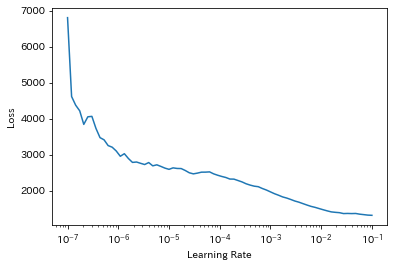

In [31]:
start_lr=1e-7
end_lr=10
r = learn.lr_find(start_lr=start_lr,
                  end_lr=end_lr,
                  num_it=100,
                  stop_div=True,
                  suggest_funcs=())

In [ ]:
model.freeze_feature_extractor()
if TEST_RUN:
  learn.fit_one_cycle(1, lr_max=1e-4)
else:
  neptune.create_experiment()
  learn.fit(20, cbs=[NeptuneCallback(log_model_weights=False), ParamScheduler({"lr": SchedExp(1e-3, 1e-4)})] )
  learn.save("/content/drive/MyDrive/data/models/hubert_cp_jp_learn",
            with_opt=True)
  learn.model.save_pretrained("/content/drive/MyDrive/data/models/hubert_cp_jp")
  with open("/content/drive/MyDrive/data/models/hubert_cp_jp/tok.pkl", "wb") as f:
    pickle.dump(tok.tokenizer, f)


https://app.neptune.ai/jjs/itps-language-model/e/IT-83


epoch,train_loss,valid_loss,perplexity,wer,cer,time
0,392.027191,333.178894,inf,0.902231,0.774884,16:32


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Invalid metric value: inf for channel epoch__perplexity. Metrics with nan or +/-inf values will not be sent to server


Better model found at epoch 0 with cer value: 0.7748836529315271.


In [ ]:
if TEST_RUN:
  learn.fit_one_cycle(1, lr_max=1e-4)
else:
  neptune.create_experiment()
  learn.fit(10, cbs=[NeptuneCallback(log_model_weights=False), ParamScheduler({"lr": SchedExp(1e-3, 1e-4)})] )
  learn.save("/content/drive/MyDrive/data/models/hubert_cp_jp_learn",
            with_opt=True)
  learn.model.save_pretrained("/content/drive/MyDrive/data/models/hubert_cp_jp")
  with open("/content/drive/MyDrive/data/models/hubert_cp_jp/tok.pkl", "wb") as f:
    pickle.dump(tok.tokenizer, f)

In [ ]:
test_datasets = [DatasetConfig(name='jsut', split='test', lang=None, kind=None),
                DatasetConfig(name='nict_spreds', split='test', lang='jp', kind=None)]
tp, tdf = get_datasets(test_datasets)

In [ ]:
tdf["audio_length"] = apply_parallel(tdf["filename"], get_audio_length, 16)
tdf = tdf[tdf["audio_length"]<15].reset_index(drop=True)
tdf = tdf[~tdf["text"].isna()].reset_index(drop=True)

abt = AudioBatchTransform()
t_tfms = TfmdLists(tdf, abt)

In [ ]:
if TEST_RUN:
  t_tfms = TfmdLists(tdf.iloc[:100], abt)
else:
  t_tfms = TfmdLists(tdf, abt)

In [ ]:
t_dl = dls.new(t_tfms)

In [ ]:
learn.cbs

In [ ]:
learn.remove_cb(learn.cbs[4]).validate(dl=t_dl)

In [ ]:
import pprint
def get_preds(xs):
  preds=learn.model(xs)
  pred_logits=preds.logits
  pred_ids=TensorText(np.argmax(pred_logits.detach().cpu().numpy(), axis=-1))
  pred_str = tok.batch_decode(pred_ids)
  return pred_str
  
for xs, y in iter(t_dl):
  print(wer(learn.model(xs), y))
  print(cer(learn.model(xs), y))
  pprint.pprint(dict(enumerate(list(zip(get_preds(xs), tok.batch_decode(y))))))
  break


In [ ]:
comp = [(get_preds(xs), tok.batch_decode(y)) for xs, y in iter(t_dl)]

In [ ]:
for i, (x_pair, y_pair) in enumerate(comp):
  print("Pred: ", x_pair[0])
  print("Targ: ", y_pair[0])
  print("Pred: ", x_pair[1])
  print("Targ: ", y_pair[1])
  if (i+1 % 10) == 0:
    break


In [ ]:
if not TEST_RUN:
  modelpath = Path("/content/drive/MyDrive/data/models/audio_jp/hubert/")
  if not os.path.exists(modelpath):
    os.mkdir(modelpath)
  learn.save(modelpath / "export_hubert")
  learn.model.save_pretrained(modelpath / "hubert_ft")
  with open(modelpath / "hubert_ft" / "tok.pkl", "wb") as f:
    pickle.dump(tok.tokenizer, f)
  torch.save(learn.model, str(modelpath / "export_torch_model.pth"))

In [ ]:
neptune.stop()
